# This part is basically for testing the various classifers and program formulation

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import emotion_analysis

In [ ]:
Emotion = emotion_analysis.EmotionAnalysis()

In [ ]:
inp, lab = Emotion.prepare_dataset('data')

In [ ]:
from random import shuffle
import numpy as np
dataset = zip(inp, lab)
shuffle(dataset)
inp, lab = zip(*dataset)
import sklearn.preprocessing
#scaler = sklearn.preprocessing.StandardScaler().fit(inp)
#inp = scaler.transform(inp)

In [ ]:
Emotion.write_to_csv(inp, lab, 'dataset.csv')

In [ ]:
# Random Forest : Better performance
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, max_depth = 100000, n_jobs = -1, oob_score = True, min_samples_split = 10 )
scores = cross_validation.cross_val_score(clf, inp, lab, cv=5)
clf = clf.fit(inp[0:int(len(inp)*3/float(4))],lab[0:int(len(inp)*3/float(4))])
#clf = clf.fit(inp, lab)

In [ ]:
scores.mean()
print clf.oob_score_
print max(clf.feature_importances_)
print min(clf.feature_importances_)
print clf.classes_

In [ ]:
# KNN classifier : Good performance

#from sklearn.neighbors import KNeighborsClassifier
#clf = KNeighborsClassifier()
#clf = clf.fit(inp[0:int(len(inp)*3/float(4))],lab[0:int(len(inp)*3/float(4))])
#clf = clf.fit(inp, lab)

In [ ]:
# SVM with RBF : Worst performance

#from sklearn import svm
#clf = svm.SVC(kernel = 'rbf')
#clf = clf.fit(inp[0:int(len(inp)*3/float(4))],lab[0:int(len(inp)*3/float(4))])
#clf = clf.fit(inp, lab)

In [ ]:
# Naive Bayes Classifier : Poor performance

#from sklearn.naive_bayes import GaussianNB
#clf = GaussianNB()
#clf = clf.fit(inp[0:int(len(inp)*3/float(4))],lab[0:int(len(inp)*3/float(4))])

In [ ]:
pred_lab = clf.predict(inp[int(len(inp)*3/float(4)):])
act_lab = lab[int(len(inp)*3/float(4)):]
#pred_lab = clf.predict(inp)
#act_lab = lab

In [ ]:
import numpy as np
from __future__ import division
accuracy = np.sum([1 for i in range(len(pred_lab)) if pred_lab[i]==act_lab[i]])/len(pred_lab)
print "Accuracy = "+str(accuracy)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(act_lab, pred_lab)
print "Precision = "+str(precision)+"\nRecall = "+str(recall)+"\nF1 Score = "+str(f1_score)

In [ ]:
import collections
print "Actual    = "+str(collections.Counter(act_lab))
print "Predicted = "+str(collections.Counter(pred_lab))

In [ ]:
Emotion.test_classifier(clf, [inp, lab])

In [ ]:
Emotion.evaluate(clf, 'negative_1.wav')

##  The following part can be used to predict emotion for a recorded voice and a new audio file

In [ ]:
#To accept an audio data and predict its emotion
import pyaudio
import wave
import scipy.io.wavfile as wav

FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 1024
RECORD_SECONDS = 10
WAVE_OUTPUT_FILENAME = "file.wav"
 
audio = pyaudio.PyAudio()
 
# start Recording
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK)
print "recording..."
frames = []
 
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
print "finished recording"
 
 
# stop Recording
stream.stop_stream()
stream.close()
audio.terminate()
 
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()

import feature_extractor
Extractor = feature_extractor.FeatureExtractor()
f = Extractor.extract_features('file.wav')

plt.plot(wav.read('file.wav')[1])
plt.show()

clf.predict([f])

In [ ]:
#To read an audio file and predict its emotion 
import feature_extractor
Extractor = feature_extractor.FeatureExtractor()
f = Extractor.extract_features('calls\\9969957664_TaiyubM_2016-01-07-15-11-09.wav')
clf.predict([f])

## This part tests the class written.

In [1]:
#To test the class written
import emotion_analysis
emo = emotion_analysis.EmotionAnalysis()

In [2]:
inp, lab = emo.prepare_dataset('data')

Read audio file 'data\negative_38.wav', count: 100
Read audio file 'data\neutral_221.wav', count: 200
Read audio file 'data\neutral_490.wav', count: 300
Read audio file 'data\positive_303.wav', count: 400
Read audio file 'data\positive_55.wav', count: 500


In [3]:
clf = emo.train_classifier([inp, lab])

In [4]:
precision, recall, f1_score = emo.test_classifier(clf, [inp, lab])

In [5]:
f1_score

array([ 0.97087379,  0.97982709,  0.98378378])

In [6]:
import scipy.io.wavfile as wav
emo.evaluate(clf,  audio_signal = wav.read('file.wav'))

IOError: [Errno 2] No such file or directory: 'file.wav'

## This part is useful for creating custom training dataset, from the recorded Edelweiss sales call. 
It opens each call and plays it into chunks of 20 sec each and then asks me for a label for those 20 sec of call. 

In [ ]:
import pyaudio
import scipy.io.wavfile as wav
from __future__ import division
import math
from os import listdir
from os.path import isfile, join

segments = []

path = "calls"
c_total = 0
c_read = 0
c_skipped = 0
audio_files = [f for f in listdir(path) if isfile(join(path, f))]
for audio_file in audio_files:
    c_total+=1
    print "Reading file: "+str(c_total)
    try:
        rate_sig, sig = wav.read(join(path, audio_file))
        c_read+=1
    except:
        c_skipped+=1
        continue
    for i in range(int(math.ceil(len(sig)/(rate_sig*20)))):
        segments.append(sig[i*(rate_sig*20):i*(rate_sig*20) + rate_sig*20])
print "\n\n"
print "Total files: "+str(c_total)
print "Read files: "+str(c_read)
print "Skipped files:"+str(c_skipped)

In [ ]:
FORMAT = pyaudio.paInt16
CHANNELS = 1

map_key_to_emotion = {'1':'negative','2':'neutral', '3':'positive'}

p = pyaudio.PyAudio()  
#open stream  
stream = p.open(format = FORMAT,  
                channels = CHANNELS,  
                rate = rate_sig,  
                output = True)  
#read data
count_label = 0
for segment in segments:
    count_label+=1
    stream.write(segment[0:len(segment)/2])
    stream.write(segment[len(segment)/2:])
    segment_label = map_key_to_emotion[raw_input()]
    
    wav.write("data\\"+segment_label+"_"+str(count_label)+".wav", rate_sig, segment)


#stop stream  
#stream.stop_stream()  
#stream.close()  

#close PyAudio  
#p.terminate()  

In [ ]:
rate, data = wav.read('negative_1.wav')
stream.write(data)

## This part will perform three things for any call:
1. Predict the emotion in the entire call.
2. Predict the emotion transition between the first half and the second half of the call.
3. Predict the emotion in 20 second segments and plot a histogram of emotions or give the count of emotions.

Enter the name of the call file name.
> 9824010555_AmritaR_2016-04-22-16-09-58.wav


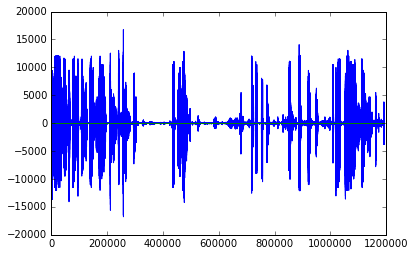

In [16]:
import scipy.io.wavfile as wav
import math
file_name = raw_input("Enter the name of the call file name.\n> ")
rate_sig, sig = wav.read(file_name)

plt.plot(sig)
plt.plot((0,len(sig)),(0,0),'g')
plt.show()

complete_call_result = emo.evaluate(clf, audio_signal = (rate_sig, sig))
first_half_result = emo.evaluate(clf, audio_signal = (rate_sig, sig[:int(len(sig)/2)]))
second_half_result = emo.evaluate(clf, audio_signal = (rate_sig, sig[int(len(sig)/2):]))
segment_result = []
for i in range(int(math.ceil(len(sig)/(rate_sig*20)))):
    segment_result.append(emo.evaluate(clf, audio_signal = (rate_sig, sig[i*rate_sig*20:i*rate_sig*20+rate_sig*20])))

Overall call result: neutral
Trainsition: neutral --> neutral


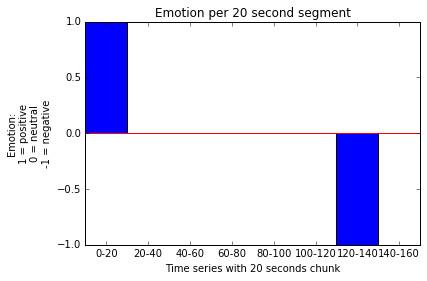

In [17]:
import numpy as np
from __future__ import division
print "Overall call result: "+complete_call_result
print "Trainsition: "+first_half_result+" --> "+second_half_result
map_dict = {'negative':-1, 'neutral':0, 'positive':1}
mapped_segment_result = [map_dict[result] for result in segment_result]
index = [i for i in range(len(mapped_segment_result))]
index = np.asarray(index)
bar_width = 1
plt.plot((0,index[-1]+1),((0,0)), 'r')
plt.bar(index, mapped_segment_result, bar_width)
plt.xticks(index + bar_width/2 , (str(i*20)+'-'+str((i+1)*20) for i in index)) 
plt.xlabel('Time series with 20 seconds chunk')
#plt.axes([0, 100, -2, 2])
plt.ylabel('Emotion:\n1 = positive\n0 = neutral\n-1 = negative')
plt.title('Emotion per 20 second segment')
plt.show()